<a href="https://colab.research.google.com/github/geoskimoto/SNOTEL-Change-Detection/blob/main/ChangeDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# KeyError: 'ns2:getDataResponse' comes up if the station is not in [].

## Library Imports

In [7]:
try:
    import xmltodict
    print("module 'xmltodict' is installed")
except ModuleNotFoundError:
  !pip install xmltodict

In [8]:
!pip install statsmodels==0.12.1

     |████████████████████████████████| 9.5MB 7.8MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import scipy.stats as stats
# import statsmodels.api as sm
from functools import reduce
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
import datetime
import statsmodels.tsa.filters as filters
from statsmodels.tsa.filters.bk_filter import bkfilter
from sklearn.linear_model import LassoCV, RidgeCV, HuberRegressor


import requests
import xmltodict



## Helper Functions

### Web Service

In [10]:
# Web Call to Access and Download Data of a Single Station from AWDB Web Service (SOAP API)

def SOAP_Call(stationtriplets, elementCD, begindate, enddate):
  global xml, dict_of_xml, df
  # Create a dictionaries to store the data
  headers = {'Content-type': 'text/soap'}
  # current_dictionary = {}
  
  # Define Web Service URL
  URL = "https://wcc.sc.egov.usda.gov/awdbWebService/services?WSDL"

  # Define Parameters for SOAP Elements (getData:current and getCentralTendencyData:normals)
  SOAP_current = '''
  <?xml version="1.0" encoding="UTF-8"?>
  <SOAP-ENV:Envelope xmlns:SOAP-ENV="http://schemas.xmlsoap.org/soap/envelope/" xmlns:q0="http://www.wcc.nrcs.usda.gov/ns/awdbWebService" xmlns:xsd="http://www.w3.org/2001/XMLSchema" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance">
    <SOAP-ENV:Body>
      <q0:getData>
        <stationTriplets>STATIONTRIPLETS</stationTriplets>
        <elementCd>ELEMENTCD</elementCd>   
        <ordinal>1</ordinal>
        <duration>DAILY</duration>
        <getFlags>false</getFlags>
        <beginDate>BEGINDATE</beginDate>
        <endDate>ENDDATE</endDate>
        <alwaysReturnDailyFeb29>false</alwaysReturnDailyFeb29>   
      </q0:getData>
    </SOAP-ENV:Body>
  </SOAP-ENV:Envelope>

  '''.strip()
  #Read GetData documents - If <alwaysReturnDailyFeb29> is set to true, will set a null for every non leap year on the 29th,  
  #which breaks this request when selecting date ranges that include Feb 29.
  #Possible element codes: PREC, WTEQ (Water Equivalent/SWE)
  
  # Post SOAP Elements to AWDB Web Service and process results - getData
  SOAP_current = SOAP_current.replace("ELEMENTCD", elementCD)
  SOAP_current = SOAP_current.replace("STATIONTRIPLETS", stationtriplets)
  SOAP_current = SOAP_current.replace("BEGINDATE", begindate)
  SOAP_current = SOAP_current.replace("ENDDATE", enddate)

  #Send request to server and receive xml document
  xml = requests.post(URL, data=SOAP_current, headers=headers)

  #convert xml document to a dictionary, extract values putting them in a dataframe.  XML's aren't the easiest to parse and extract data from, so this is a nice work around.
  dict_of_xml = xmltodict.parse(xml.text)
  df = dict_of_xml['soap:Envelope']['soap:Body']['ns2:getDataResponse']['return']['values']

  #Null values are given as OrderedDictionaries with lots of text, while actual values are given as strings.  This converts all the OrderedDictionaries into actual null/none values, and converts all values that were given as strings into float numbers.
  df = pd.DataFrame(map(lambda i: float(i) if type(i) == str else None, df))

  #Since invidual dates aren't associated with the values in the xml document, have to create a range of dates bw the begindate and endate, which is then added to the dataframe.
  df['Date'] = pd.date_range(begindate,enddate,freq='d')
  df.columns = [f'{elementCD}','Date']
  df.set_index('Date', inplace=True)

  return df.iloc[:,0].astype(float)  #For some reason converting strings to floats can only be done in return.


In [11]:
# Function to Download Multiple Stations at a time from AWDB Web Service.  
# Not the most efficient way as it sends multiple requests.  Should change SOAP to accept multiple inserted stationtriplets in future.

def getData(stations, parameter_of_interest, begindate, enddate):
  
  try:
    data_singleDF = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True, how='outer'), [SOAP_Call(stationtriplets=j,elementCD=parameter_of_interest,begindate=begindate,enddate=enddate) for j in stations])  
    data_singleDF.columns = [f'{j}' for j in stations]
  except ValueError:
    print('One or more of the values for an inputed date in the Air-Water Database (AWDB) is null.  Need to either select a different date or update the value using DMP in AWDB.')

  return pd.DataFrame(data_singleDF)

In [12]:
# df = getData(['464:OR:SNTL'], 'WTEQ', '01/01/2020', '05/25/2021')

### Change Detection

#### Double Mass

In [13]:
def double_mass(stations, parameter, begindate, enddate, month=0):  
  # global site_list, df_merged, df2
 #Compile and filter data with respect to inputs:
  # site_list = [ORWA_Sites2[i][parameter] for i in stations] #Use if loading data from a csv
  site_list = [getData([i], parameter, begindate, enddate) for i in stations]
 
  df_merged = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True, how='outer'), site_list).dropna()
  df2 = df_merged
  df2.columns = [f'{i} {parameter}' for i in stations]
  
  if month == 0:
    df2 = df2
    # print(df2) 
  elif month > 0 or month < 12:
    df2 = df2[df2.index.month == month] #need to understand indexes and datatime indices better.  When to use .dt accessor?

#Double Mass Analysis
  x=pd.DataFrame(abs(df2.iloc[:,0].diff()).cumsum())
  x.columns = ['x']
  y=pd.DataFrame(np.add.reduce([abs(df2.iloc[:,i].diff()).cumsum() for i in range(len(stations))]))  #might want to try to use pd.apply(np.cumsum) here to reduce to maintain datetime index
  y.index = x.index
  y.columns= ['y']

#Plot the data
  customdata_list = [df2.iloc[:,0], x, y]
  customdata = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True, how='outer'), customdata_list)
  customdata.reset_index(inplace=True)

  fig = make_subplots(
      rows=1, cols=1,
      subplot_titles=(f'{parameter} Double Mass Curve', f'Yearly {parameter} Double Mass Curve')
  )

  fig.add_trace(go.Scatter(
      x=x.iloc[:,0],
      y=y.iloc[:,0],
      mode='lines',
      customdata=customdata,
      hovertemplate = '<b>Date: %{customdata[0]}</b>', #<br>Site of Interest - Cumulative {parameter}: %{customdata[2]:.2f}</br>Comparison Site(s) - Cumulative SWE (in): %{customdata[3]:.2f}<br>Site of Interest - SWE (in): %{customdata[1]:.2f}</br>',
      # hovertemplate = f'<b>Date: %{customdata.iloc[:,0]}</b><br>Site of Interest - Cumulative:  %{customdata.iloc[:,2]}</br>', #Comparison Site(s) - Cumulative {parameter}: {customdata[3]}<br>Site of Interest - Daily {parameter}: {customdata[1]}</br>',
      name = 'Double mass curve'
  ), 
  row=1, col=1)

  fig.update_xaxes(title_text= f"Cumulative {parameter} at {stations[0]}", row=1, col=1)
  fig.update_yaxes(title_text=f"Total Cumulative {parameter} of Comparison Sites <br>{stations[1::]}</br>", row=1, col=1)

  fig.update_layout(
   height=800,
   width=1200
  )
  
  fig.show()

In [43]:
#Double Mass with regression model fitting pre-event data

def double_mass(stations, parameter, begindate, enddate, eventdate, month=0): 
  
  global site_list, df_merged, df2, x, y, x_array, y_array
 #Compile and filter data with respect to inputs:
  # site_list = [ORWA_Sites2[i][parameter] for i in stations] #Use if loading data from a csv
  site_list = [getData([i], parameter, begindate, enddate) for i in stations]
 
  df_merged = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True, how='outer'), site_list).dropna()
  df2 = df_merged
  df2.columns = [f'{i} {parameter}' for i in stations]
  
  if month == 0:
    df2 = df2
    # print(df2) 
  elif month > 0 or month < 12:
    df2 = df2[df2.index.month == month] #need to understand indexes and datatime indices better.  When to use .dt accessor?

#Double Mass Analysis
  x=pd.DataFrame(abs(df2.iloc[:,0].diff()).cumsum())
  x.columns = ['x']
  y=pd.DataFrame(np.add.reduce([abs(df2.iloc[:,i].diff()).cumsum() for i in range(len(stations))]))  #might want to try to use pd.apply(np.cumsum) here to reduce to maintain datetime index
  y.index = x.index
  y.columns= ['y']

#Best fit regression line 
  # PreEvent_x =  
  # regr = RidgeCV(alphas=(0.001,0.01,0.1,1,10,100,1000))
  # regr.fit(x[:eventdate].dropna(), y[:eventdate].dropna())
  # predictions = regr.predict(x[:eventdate].dropna())
  x_array = np.array(x[eventdate:].iloc[:,0])
  y_array = np.array(y[eventdate:].iloc[:,0])
  m, b = np.polyfit(x_array, y_array, 1)

#Plot the data
  customdata_list = [df2.iloc[:,0], x, y]
  customdata = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True, how='outer'), customdata_list)
  customdata.reset_index(inplace=True)

  fig = make_subplots(
      rows=1, cols=1,
      subplot_titles=(f'{parameter} Double Mass Curve', f'Yearly {parameter} Double Mass Curve')
  )

  fig.add_trace(go.Scatter(
      x=x.iloc[:,0],
      y=y.iloc[:,0],
      mode='lines',
      customdata=customdata,
      hovertemplate = '<b>Date: %{customdata[0]}</b>', #<br>Site of Interest - Cumulative {parameter}: %{customdata[2]:.2f}</br>Comparison Site(s) - Cumulative SWE (in): %{customdata[3]:.2f}<br>Site of Interest - SWE (in): %{customdata[1]:.2f}</br>',
      # hovertemplate = f'<b>Date: %{customdata.iloc[:,0]}</b><br>Site of Interest - Cumulative:  %{customdata.iloc[:,2]}</br>', #Comparison Site(s) - Cumulative {parameter}: {customdata[3]}<br>Site of Interest - Daily {parameter}: {customdata[1]}</br>',
      name = 'Double mass curve'
  ), 
  row=1, col=1)

  fig.add_trace(go.Scatter(
      x=x.loc[eventdate,:],
      y=y.loc[eventdate,:],
      mode='markers',
      name = 'Pre-event regression line'
  ), 
  row=1, col=1)

  fig.add_trace(go.Scatter(
      x=x_array,
      y= m*x_array + b,
      mode='lines',
      name = 'Pre-event regression line'
  ), 
  row=1, col=1)

  fig.update_xaxes(title_text= f"Cumulative {parameter} at {stations[0]}", row=1, col=1)
  fig.update_yaxes(title_text=f"Total Cumulative {parameter} of Comparison Sites <br>{stations[1::]}</br>", row=1, col=1)

  fig.update_layout(
   height=800,
   width=1200
  )
  
  fig.show()

#### Pre/Post plots

In [ ]:
#Ticks are overlapping due to plotting xaxis for both PreMean and PostMean

def PrePostPlots(station, parameter, begindate, enddate, eventdate):
  global df, PreEvent, PreMean, PostEvent, PostMean, Means
  df = getData(station, parameter, begindate, enddate)
  # df['Date'] = pd.to_datetime(df['Date'])
  # df = df.set_index(df['Date'])

  #Remove Feb. 29/leap year as it messes everything up
  df = df[~((df.index.month == 2) & (df.index.day == 29))]
  df['month-day'] = df.index.strftime('%m-%d')
  # pivoted = df.pivot(index="WTEQ", columns="month-day")

  PreEvent = df[:eventdate]
  PostEvent = df[eventdate:]

  PreMean = PreEvent.groupby(by='month-day').mean()
  PostMean = PostEvent.groupby(by='month-day').mean()
  # PreMean = PreEvent.groupby(pd.Grouper(freq='D')).mean()
  # df[(df['Delivery Date'].dt.year == 1970) | (df['Delivery Date'] >= sixmonthago)]
  # PreMean['Date'] = pd.date_range('01-01-1990','12-31-1990',freq='d').strftime('%m-%d')
  # PreMean.columns = ['WTEQ','Date']
  # PreMean.set_index('Date', inplace=True)
  # return PreEvent #, PreMean

  #In order for xaxis labels not to be duplicated creating overlapping values on xaxis, combine PreMean and PostMean into single df so they both share a single 'month-day' index.
  Means = pd.merge(PreMean, PostMean, right_index=True, left_index=True)
  # Means.columns = []
  # return df.groupby([df.index.day,df.index.month]).mean()

  # fig = make_subplots(
  #     rows=1, cols=1,
      # subplot_titles=(f'{parameter} Double Mass Curve', f'Yearly {parameter} Double Mass Curve')
  # )
  # PreMean.reset_index(inplace=True)
  # PostMean.reset_index(inplace=True)

  # Means.reset_index(inplace=True)
  # Means['month-day'].astype(str)
  # fig = go.Figure()
  # fig.add_trace(go.Scatter(
  #     x=Means.index.values,
  #     y=Means['WTEQ_x'],
  #     mode='lines'
  # ))

  # fig.add_trace(go.Scatter(
  #     x=Means.index.values,
  #     y=Means['WTEQ_y'],
  #     mode='lines'
  # ))

  # fig.update_layout(
  #  height=800,
  #  width=1200
  # )
  
  # fig.show()
 

  years_before = len(PreEvent)/365
  years_after = len(PostEvent)/365

  
  # Means.reset_index(inplace=True)

  fig, ax = plt.subplots(figsize=(20,12))
  ax.plot(Means.index.values, Means[f'{parameter}_x'], color='blue', label = 'Daily Mean Values before Event')
  ax.plot(Means.index.values, Means[f'{parameter}_y'], color='red', label = 'Daily Mean Values after Event')
  # ax.set(xticks=np.arange(PostMean['month-day'].size), xticklabels=datelabels) #Same as plt.xticks
  # plt.tick_params(axis = 'x', width = 1, which='major') #left = False, bottom = False)
  # ax.set_xticks(df['month-day']) #step 5 digits
  # https://stackoverflow.com/questions/6682784/reducing-number-of-plot-ticks
  ax.xaxis.set_major_locator(plt.MaxNLocator(12))
  # ax.set_xticks()
  plt.legend()
  plt.text(0, 5, 'Years of data before event: ' + f'{years_before:.2f}', fontsize = 16)
  plt.text(0, 0, 'Years of data after event: ' + f'{years_after:.2f}', fontsize = 16)
  plt.show();


In [ ]:
# a = PrePostPlots(['908:WA:SNTL'], parameter='SNWD',begindate='11/25/2005',enddate='12/18/2019', eventdate='01/01/2010')

#### Ratio of SWE to Water Year Total Precip

In [ ]:
def SWEtoPREC(station, begindate, enddate, eventdate):
  global RatioPre, RatioPost, WTEQ_PreEvent, WTEQPreMean
  WTEQ = getData(station, 'WTEQ', begindate, enddate)
  PREC = getData(station, 'PREC', begindate, enddate)
  
  # df['Date'] = pd.to_datetime(df['Date'])
  # df = df.set_index(df['Date'])

  #Remove Feb. 29/leap year as it messes everything up
  WTEQ = WTEQ[~((WTEQ.index.month == 2) & (WTEQ.index.day == 29))]
  WTEQ['month-day'] = WTEQ.index.strftime('%m-%d')
  PREC = PREC[~((PREC.index.month == 2) & (PREC.index.day == 29))]
  PREC['month-day'] = WTEQ.index.strftime('%m-%d')

  WTEQPreMean = WTEQ[:eventdate].groupby(by='month-day').mean()
  WTEQPostMean = WTEQ[eventdate:].groupby(by='month-day').mean()

  PRECPreMean = PREC[:eventdate].groupby(by='month-day').mean()
  PRECPostMean = PREC[eventdate:].groupby(by='month-day').mean()

  RatioPre = WTEQPreMean['WTEQ']/PRECPreMean['PREC']
  RatioPost = WTEQPostMean['WTEQ']/PRECPostMean['PREC']

  years_before = len(WTEQ[:eventdate])/365
  years_after = len(WTEQ[eventdate:])/365

  fig, ax = plt.subplots(figsize=(20,12))
  ax.plot(RatioPre.index, RatioPre[:], color='blue', label = 'SWE:PREC before Event')
  ax.plot(RatioPost.index.values, RatioPost[:], color='red', label = 'SWE:PREC after Event')
  # ax.set(xticks=np.arange(PostMean['month-day'].size), xticklabels=datelabels) #Same as plt.xticks
  # plt.tick_params(axis = 'x', width = 1, which='major') #left = False, bottom = False)
  # ax.set_xticks(df['month-day']) #step 5 digits
  # https://stackoverflow.com/questions/6682784/reducing-number-of-plot-ticks
  ax.xaxis.set_major_locator(plt.MaxNLocator(12))
  # ax.set_xticks()
  plt.xlabel('Month-Day')
  plt.ylabel('Ratio of SWE to Water Year Total Precipitation')
  plt.legend()
  plt.text(0, .03, 'Years of data before event: ' + f'{years_before:.2f}', fontsize = 16)
  plt.text(0, 0, 'Years of data after event: ' + f'{years_after:.2f}', fontsize = 16)
  plt.show();


In [ ]:
# WTEQPreMean

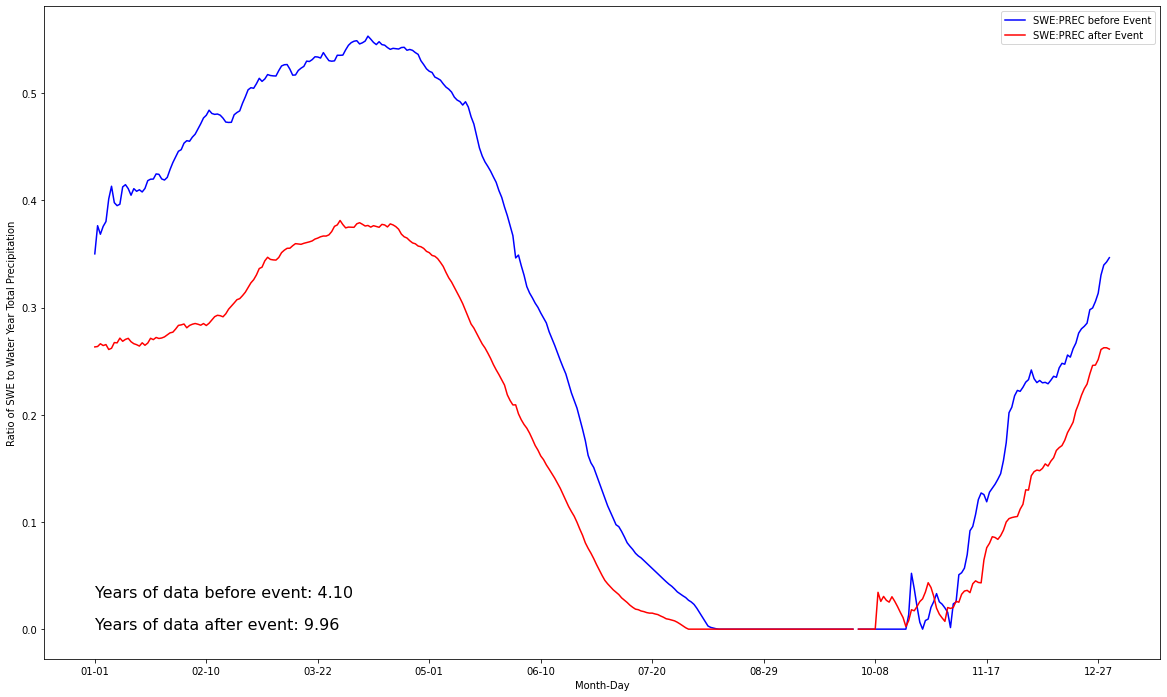

In [ ]:
SWEtoPREC(['908:WA:SNTL'],begindate='11/25/2005',enddate='12/18/2019', eventdate='01/01/2010')

#### Peak SWE and Meltout Dates

# Test Runs

In [ ]:
# getData(['AGP:BC:MSNT'], 'WTEQ', '11/25/2010', '12/18/2019')

#### Double Mass

In [44]:
double_mass(['912:WA:SNTL','908:WA:SNTL','791:WA:SNTL'], 'PREC', '2010-01-01', '2019-01-01', '2015-10-01')